# 微博数据分析

数据包含微博 500 个用户 2020-1-20 到 2020-3-25 号微博正文，包含字段：微博id，微博正文，原始图片url，被转发微博原始图片url，是否为原创微博，微博视频url，发布位置，发布时间，发布工具，点赞数，转发数，评论数


## 导入库/参数设置

In [1]:
import os
import pandas as pd
from tqdm import tqdm
from snownlp import SnowNLP
from wordcloud import WordCloud
from matplotlib import pyplot as plt

from clean_data import WeiboPreprocess 

In [29]:
start_date = "2020-1-20"
font_path = "../data/Microsoft YaHei Mono.ttf"
post_data_path = "../data/user_data"
stop_words_path = "../data/dictionary/stopwords.txt"
positive_words_path = "../data/dictionary/ntusd-positive.txt"
negative_words_path = "../data/dictionary/ntusd-negative.txt"
keyword_to_delete = ["微博之夜", "关注并转发", "翻转开运卡", "我的新年心愿已发出", "由于作者设置"]

In [30]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 100)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',200)

## 获取数据

In [31]:
def get_data(file_path):
    total = pd.DataFrame()
    # read all xlsx files
    for root, dirs, files in tqdm(os.walk(file_path)):
        # merge all post
        for file in files:
            df = pd.read_csv(os.path.join(root, file))
            df.drop(columns=["微博id", "原始图片url", "被转发微博原始图片url", "微博视频url", "发布位置", "发布工具"], inplace=True)
            total = total.append(df)
    total.columns = ["post", "is_original", "time", "like", "repost", "comment"]
    total["time"] = pd.to_datetime(total["time"]).dt.date
    total.sort_values("time", inplace=True)
    total.reset_index(drop=True, inplace=True)
    # concatenate posts by date
    # total = total.groupby("time")["post"].sum()
    return total

## 查看数据基本信息

In [32]:
data = get_data(post_data_path)
data.head(60)

501it [00:02, 216.57it/s]


,post,is_original,time,like,repost,comment
0,转发理由:飞吻\n原始用户: SNH48-林思意\n转发内容: ！！！ 原图,False,2020-01-01,0,0,0
1,情绪稳定是家人，和关心在乎且会哄我的朋友给的礼物夸我棒棒，我就真的棒棒吧（先这样相信你们太好了呜呜呜呜呜呜呜今天实在是太难了感谢我柚让我不再怀疑自己（你真的太会哄我了，太会了！要说还算有点幸运，那就是即便我像个石头，几乎从不主动联络朋友，仍然会得到关爱（她们都好主动还暖以及今天就连流利说都在鼓励我，Sanna Marin太牛了，我也不能倒下！ [组图共2张] 原...,True,2020-01-01,4,0,0
2,转发理由:#祉攸[超话]# 辛苦了 2020健康平安一切顺利\n原始用户: DREAMCATCHER_7\n转发内容: #Dreamcatcher[超话]# #捕梦网[超话]# [] Dreamcatcher为森nia们送上2020年新年问候 祝大家新年快乐 DREAMCATCHER_7的微博视频,False,2020-01-01,1,0,0
3,分享图片 南京·南京新街口 显示地图原图,True,2020-01-01,4,0,0
4,转发理由:新年爱你@TFBOYS-王源\n原始用户: 王源RoyWang工作室\n转发内容: #王源[超话]#身着牛仔印花夹克亮相湖南卫视跨年演唱会舞台。眸中斑斓生辉，光彩兀自流动，今天@TFBOYS-王源 又一次按下播放键，把他的诚挚唱给你们听。 [组图共4张]原图,False,2020-01-01,0,0,0
5,转发理由:#祉攸[超话]# #那年金日金旼祉#\n原始用户: DREAMCATCHER_7\n转发内容: #Dreamcatcher##捕梦网#[捕梦网] 2018年1月1日各位～新年快乐！能和大家一同开启新的一年感到非常开心，想到以后还能和大家一起制造更多美好的回忆就很心动！感谢各位 爱你们哦 韩国·首尔 [组图共2张]原图,False,2020-01-01,2,0,0
6,转发理由:转发微博\n原始用户: 星闻揭秘\n转发内容: 肖战《神奇》 #肖战神奇唱跳# 舞台，好A好撩@X玖少年团肖战DAYTOY #肖战神奇# #星闻揭秘[超话]# 星闻揭秘的秒拍视频,False,2020-01-01,0,0,0
8,转发理由:转发微博\n原始用户: 为站而来DAYTOY\n转发内容: #肖战跳舞##肖战东方卫视跨年# 看看饭拍什么样跳舞也棒 唱歌也棒 你怎么这么神奇 小赞的猫儿的微博视频,False,2020-01-01,0,0,0
9,转发理由:转发微博\n原始用户: 小赞的坚果兔宝宝\n转发内容: #肖战跳舞#感觉有这个视频这个跨年算是圆满了，感谢我今年认识你并了解你，祝所有人新年快乐，祝自己生日快乐#肖战东方卫视跨年##肖战[超话]# 星闻揭秘的微博视频 郑州,False,2020-01-01,0,0,0
10,转发理由:转发微博\n原始用户: 微博综艺\n转发内容: #肖战张艺兴合唱#开启#东方卫视跨年# ，肖战@X玖少年团肖战DAYTOY 和张艺兴@努力努力再努力x 两位实力偶像同框合唱的#肖战张艺兴我们都是追梦人#，有没有惊艳到你？正经综艺片场的微博视频,False,2020-01-01,0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11412 entries, 0 to 11661
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   post         11412 non-null  object
 1   is_original  11412 non-null  bool  
 2   time         11412 non-null  object
 3   like         11412 non-null  int64 
 4   repost       11412 non-null  int64 
 5   comment      11412 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 546.1+ KB


In [7]:
data["time"].value_counts()

2020-01-17    212
2020-03-01    194
2020-01-16    190
2020-03-06    185
2020-01-01    184
2020-02-29    183
2020-01-24    180
2020-03-09    170
2020-01-13    167
2020-01-21    165
2020-03-05    164
2020-01-14    162
2020-03-27    162
2020-01-20    159
2020-03-14    157
2020-03-16    156
2020-03-07    150
2020-01-18    149
2020-01-12    148
2020-03-15    145
2020-01-15    142
2020-02-11    142
2020-01-26    141
2020-01-11    141
2020-01-06    141
2020-03-12    140
2020-03-20    140
2020-01-08    137
2020-03-10    137
2020-03-08    136
2020-02-08    135
2020-01-10    131
2020-01-27    130
2020-02-22    130
2020-02-25    130
2020-01-29    130
2020-01-07    130
2020-01-19    129
2020-01-25    129
2020-01-09    127
2020-02-07    127
2020-01-23    126
2020-03-19    123
2020-03-26    123
2020-02-14    121
2020-02-12    120
2020-03-25    120
2020-02-04    120
2020-03-18    119
2020-02-27    119
2020-02-28    118
2020-02-09    118
2020-03-13    118
2020-02-24    117
2020-03-17    116
2020-01-22

## 每日发布微博数量分布图

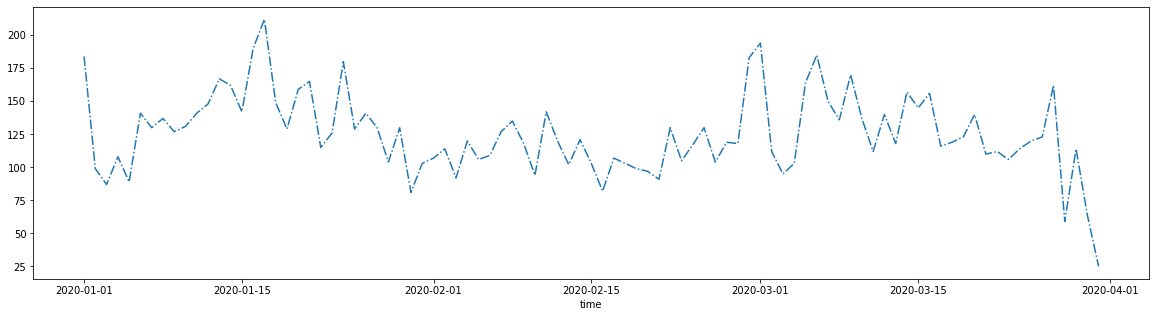

In [8]:
fig1, ax1 = plt.subplots(figsize=(20, 5))
df = data.groupby("time").count()["post"]
df.plot(ax=ax1, style='-.')
plt.show()

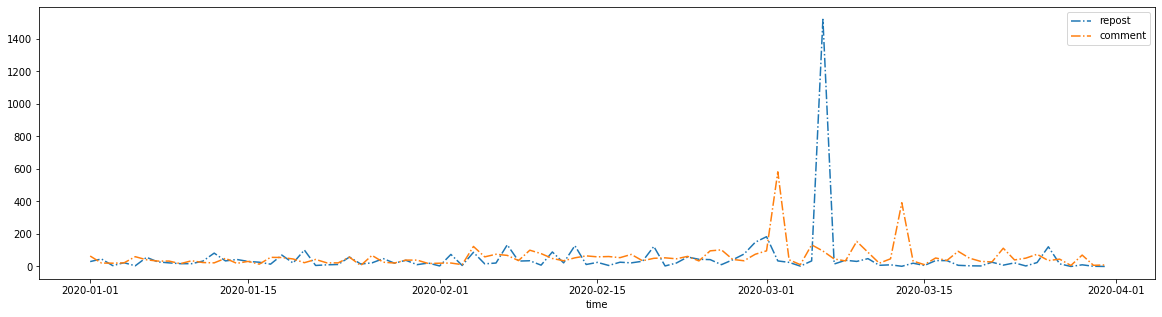

In [9]:
fig2, ax2 = plt.subplots(figsize=(20, 5))
df = data.groupby("time").sum()[["repost", "comment"]]
df.plot(ax=ax2, style='-.')
plt.show()

## 微博正文内容预处理

In [11]:
# 文本清洗/分词
data = data[~data["post"].str.contains("|".join(keyword_to_delete))]
preprocess = WeiboPreprocess()
data["post"] = data["post"].apply(lambda x: preprocess.clean(x))

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\const\AppData\Local\Temp\jieba.cache
Loading model cost 0.700 seconds.
Prefix dict has been built succesfully.


## 情感分类

In [ ]:
data = data[data["post"].str.len > 3]
data["emotion"] = data["post"].apply(lambda x: SnowNLP(x).sentiments)

## 制作高频词词云

In [12]:
# get all kinds of vocabulary
def get_vocab(vocab_path):
    vacab = set()
    with open(vocab_path, encoding="utf-8") as f:
        vocab_list = [x.strip() for x in f.readlines()]
        vacab = set(vocab_list)
    return vacab

In [13]:
# load stop words
stopwords = get_vocab(stop_words_path)

In [14]:
def gen_wordcloud(text, save_to_file):
    wc = WordCloud(font_path=font_path, width=1000, height=860, scale=2, max_words=100, stopwords=stopwords, background_color="white", collocations=False).generate(text)
    wc.to_file(save_to_file)
    plt.imshow(wc)
    plt.axis("off")

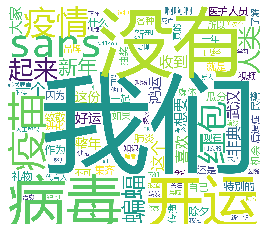

In [68]:
# generate wordcloud by date
date = "2020-1-22"
gen_wordcloud(data.groupby("time")["post"].sum()[pd.to_datetime(date).date()], os.path.join("../data/wordcloud", date + ".png"))

## 获取情绪高频词

In [ ]:
# positive_words = get_vocab(positive_words_path)
# negative_words = get_vocab(negative_words_path)

In [ ]:
# from collections import Counter
# postwords_list = data[data["is_original"]==True].groupby("time")["post"].sum()[pd.to_datetime("2020-1-20").date()].split()
# pos_words_list = [word for word in postwords_list if word in positive_words]
# neg_words_list = [word for word in postwords_list if word in negative_words]
# pos_counter = Counter(pos_words_list)
# pos_counter.most_common(10)

In [ ]:
# neg_counter = Counter(neg_words_list)
# neg_counter.most_common(10)